# **INFO5731 Assignment 5**

---


**This exercise aims to provide a comprehensive learning experience in text analysis and machine learning techniques, focusing on both text classification and clustering tasks.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100

**Full Points will be given those who present well**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

# **SENTIMENT ANALYSIS**

The objective of this assignment is to give you **hands-on experience** in applying various** sentiment analysis techniques** on real-world textual data. You are expected to explore data, apply machine learning models, and evaluate their performance

**1. Dataset Collection & Preparation**

Find a real-world dataset with text and positive, negative, and neutral sentiment labels.

Justify your dataset choice and handle **class imbalance** if needed.

**2. Exploratory Data Analysis (EDA)**

Clean and preprocess the data (tokenization, stopwords, lemmatization).

Perform EDA: class distribution, word clouds, n-gram analysis, sentence lengths, etc.

Visualize insights using relevant plots and charts.

**3. Sentiment Classification**

Apply at least three traditional ML models (e.g., SVM, Naive Bayes, XGBoost) using TF-IDF or embeddings.

If applicable, compare with a pretrained model (RoBERTa/BERT).

Tune hyperparameters and use cross-validation.

**4. Evaluation & Reporting**

Evaluate with metrics: Accuracy, Precision, Recall, F1, Confusion Matrix.

Summarize results, compare models, and reflect on what worked.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


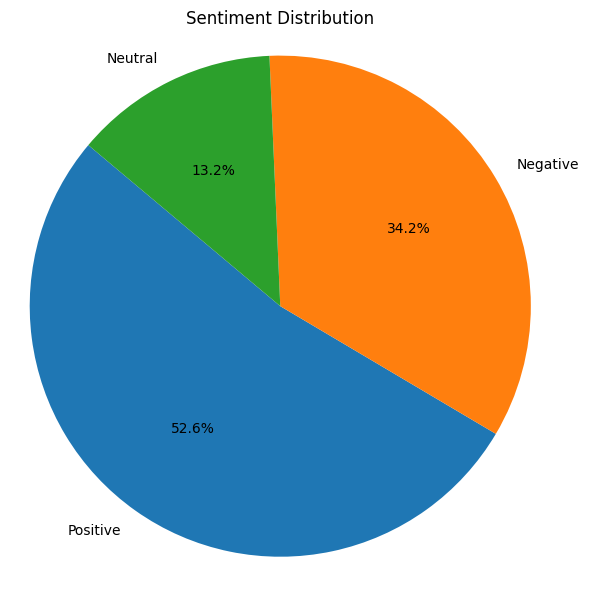

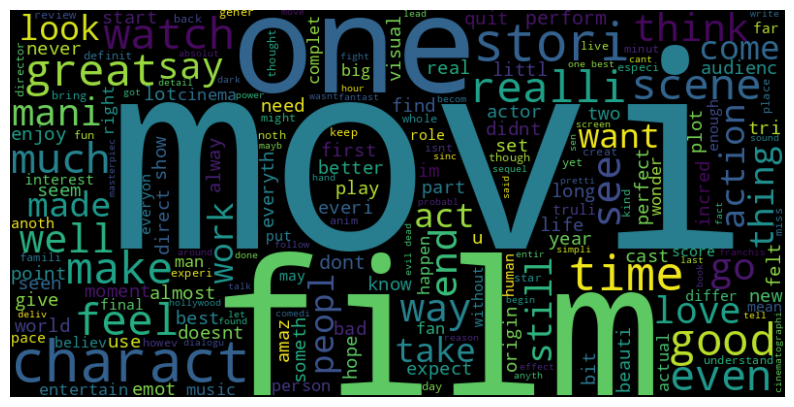

<ipython-input-8-107d0535bd23>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


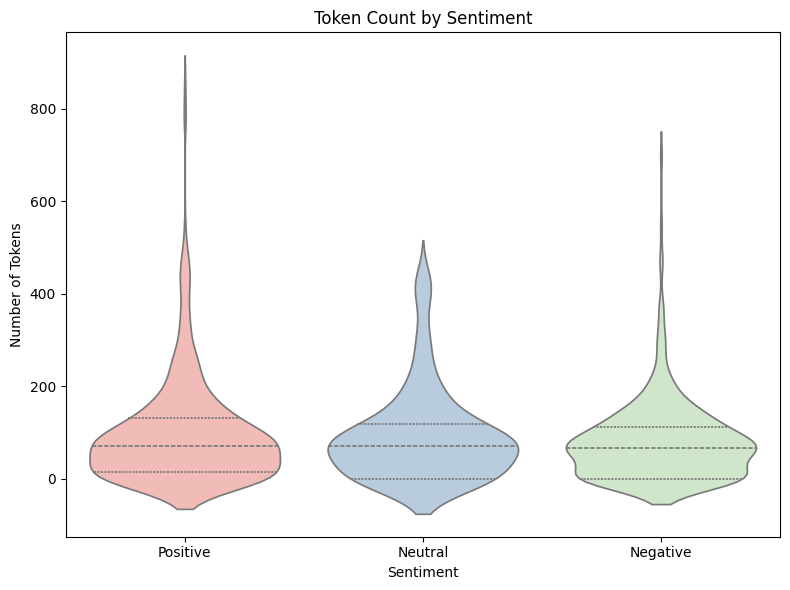

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [23:12:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


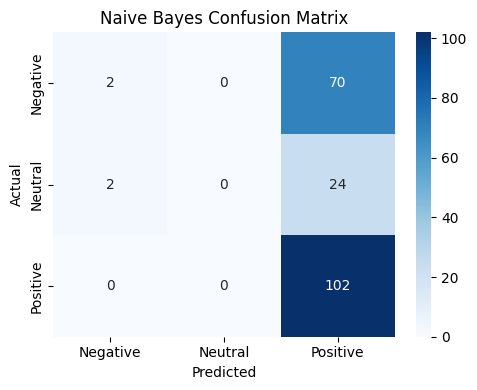

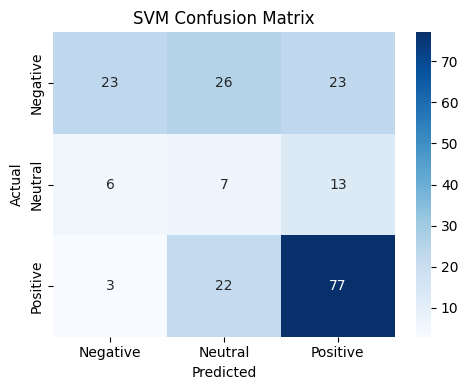

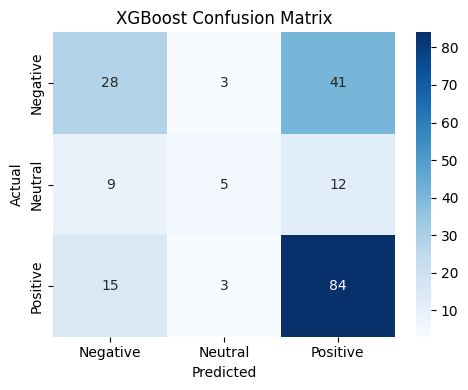


Model: Naive Bayes
Accuracy: 0.5200
Precision: 0.4454
Recall: 0.5200
F1 Score: 0.3681
--------------------------------------------------

Model: SVM
Accuracy: 0.5350
Precision: 0.6228
Recall: 0.5350
F1 Score: 0.5470
--------------------------------------------------

Model: XGBoost
Accuracy: 0.5850
Precision: 0.5656
Recall: 0.5850
F1 Score: 0.5562
--------------------------------------------------


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight

nltk.download('stopwords')
nltk.download('wordnet')

# Load & preprocess
data_path = '/content/Cleaned_reviews.csv'
review_data = pd.read_csv(data_path)
review_data['Content'] = review_data['Content'].fillna('')
review_data['Processed_Text'] = review_data['Processed_Text'].fillna('')

def map_score_to_sentiment(numeric_score):
    if numeric_score > 7:
        return 'Positive'
    elif numeric_score == 7:
        return 'Neutral'
    else:
        return 'Negative'

review_data['Sentiment'] = review_data['Score'].apply(map_score_to_sentiment)

# 1) Sentiment distribution
plt.figure(figsize=(6, 6))
counts = review_data['Sentiment'].value_counts()
plt.pie(
    counts,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.tight_layout()
plt.show()

# Text cleaning & WordCloud
english_stopwords   = set(stopwords.words('english'))
lemmatizer_instance = WordNetLemmatizer()

def clean_and_lemmatize(text_input):
    words = text_input.split()
    cleaned = [
        lemmatizer_instance.lemmatize(w.lower())
        for w in words
        if w.lower() not in english_stopwords
    ]
    return " ".join(cleaned)

review_data['Processed_Text'] = review_data['Processed_Text'].apply(clean_and_lemmatize)

combined_text = ' '.join(review_data['Processed_Text'])
word_cloud = WordCloud(width=800, height=400).generate(combined_text)
plt.figure(figsize=(10, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Recompute token counts
review_data['Token_Count'] = review_data['Processed_Text'].apply(lambda x: len(x.split()))

# 2) Token‑count distribution by sentiment
plt.figure(figsize=(8, 6))
sns.violinplot(
    x='Sentiment',
    y='Token_Count',
    data=review_data,
    inner='quartile',
    palette='Pastel1'
)
plt.title('Token Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tokens')
plt.tight_layout()
plt.show()

#  Prepare data for modeling
features = review_data['Processed_Text']
labels   = review_data['Sentiment']

label_encoder   = LabelEncoder()
encoded_labels  = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(
    features, encoded_labels,
    test_size=0.2,
    random_state=42
)

balanced_weights = compute_class_weight(
    'balanced',
    classes=np.unique(encoded_labels),
    y=encoded_labels
)
weights_dict = dict(zip(np.unique(encoded_labels), balanced_weights))

classification_models = {
    'Naive Bayes': make_pipeline(
        TfidfVectorizer(max_features=10000),
        MultinomialNB()
    ),
    'SVM': make_pipeline(
        TfidfVectorizer(max_features=10000),
        SVC(class_weight='balanced')
    ),
    'XGBoost': make_pipeline(
        TfidfVectorizer(max_features=10000),
        XGBClassifier(scale_pos_weight=weights_dict[1])
    ),
}

# Training & evaluation
evaluation_results = {}
for name, pipeline in classification_models.items():
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)

    acc   = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, preds, average='weighted'
    )
    cm = confusion_matrix(y_test, preds)

    evaluation_results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

# 3) Confusion matrix heatmaps
for model_name, metrics in evaluation_results.items():
    cm = metrics['Confusion Matrix']
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

#  Print numeric results
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for m_name, val in metrics.items():
        if m_name == 'Confusion Matrix':
            continue
        print(f"{m_name}: {val:.4f}")
    print("-" * 50)


## **Question 2 (30 Points)**

# **Text Classification**

The purpose of the question is to practice different machine learning algorithms for **text classification** as well as the performance evaluation. In addition, you are requried to conduct **10 fold cross validation** (https://scikit-learn.org/stable/modules/cross_validation.html) in the training.



The dataset can be download from canvas. The dataset contains two files train data and test data for sentiment analysis in IMDB review, it has two categories: 1 represents positive and 0 represents negative. You need to split the training data into training and validate data (80% for training and 20% for validation, https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6) and perform 10 fold cross validation while training the classifier. The final trained model was final evaluated on the test data.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



1.   **Perform EDA on test and tran dataset**

2.   **Algorithms (Minimum 4):**

*   SVM
*   KNN
*   Decision tree
*   Random Forest
*   XGBoost
*   Word2Vec
*   BERT

3. **Evaluation measurement:**

*   Accuracy
*   Recall
*   Precison
*   F-1 score


Missing values in train data:
 Sentiment    0
Review       0
dtype: int64
Missing values in test data:
 Sentiment    0
Review       0
dtype: int64


<ipython-input-7-6616df60a35b>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


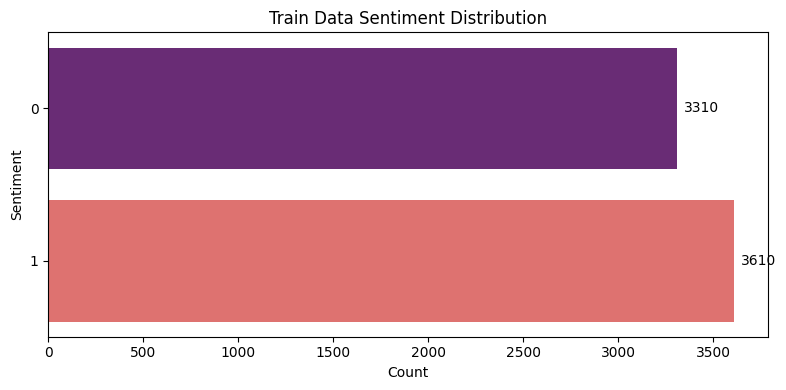

<ipython-input-7-6616df60a35b>:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


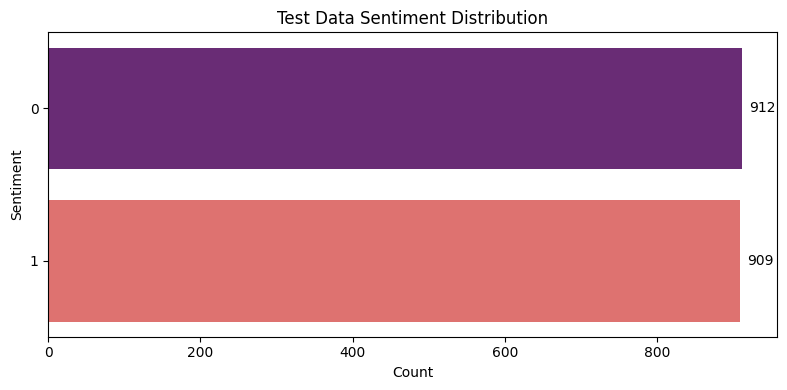


Model: SVM
Accuracy: 0.7979
Precision: 0.7757
Recall: 0.8372
F1 Score: 0.8053
Confusion Matrix:
[[692 220]
 [148 761]]
--------------------------------------------------

Model: KNN
Accuracy: 0.6996
Precision: 0.6486
Recall: 0.8691
F1 Score: 0.7428
Confusion Matrix:
[[484 428]
 [119 790]]
--------------------------------------------------

Model: Decision Tree
Accuracy: 0.6139
Precision: 0.6026
Recall: 0.6656
F1 Score: 0.6325
Confusion Matrix:
[[513 399]
 [304 605]]
--------------------------------------------------

Model: Random Forest
Accuracy: 0.7062
Precision: 0.6833
Recall: 0.7668
F1 Score: 0.7227
Confusion Matrix:
[[589 323]
 [212 697]]
--------------------------------------------------


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def parse_labeled_text(filepath):

    with open(filepath, encoding='utf-8') as file:
        lines = file.readlines()
    # Split on first whitespace only
    parsed = [line.strip().split(maxsplit=1) for line in lines if line.strip()]
    labels = [int(item[0]) for item in parsed if len(item) == 2]
    texts  = [item[1].lower() for item in parsed if len(item) == 2]
    return pd.DataFrame({'Sentiment': labels, 'Review': texts})

# Load and parse training and test sets
testing_dataset  = parse_labeled_text('/content/stsa-test.txt')
training_dataset = parse_labeled_text('/content/stsa-train.txt')


# Check for missing values
print("Missing values in train data:\n", training_dataset.isnull().sum())
print("Missing values in test data:\n", testing_dataset.isnull().sum())

def visualize_label_distribution(dataframe, chart_title):

    # Compute counts per sentiment label, sorted by label
    counts = dataframe['Sentiment'].value_counts().sort_index()
    labels = [str(l) for l in counts.index]

    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=counts.values,
        y=labels,
        palette='magma'
    )
    plt.title(chart_title)
    plt.xlabel('Count')
    plt.ylabel('Sentiment')

    # Annotate counts to the right of each bar
    for i, v in enumerate(counts.values):
        ax.text(v + max(counts.values)*0.01, i, str(v), va='center')

    plt.tight_layout()
    plt.show()


# Visualize distribution in train and test splits
visualize_label_distribution(training_dataset, "Train Data Sentiment Distribution")
visualize_label_distribution(testing_dataset,  "Test Data Sentiment Distribution")

# Text vectorization and dataset splitting

# Prepare TF-IDF features (limit to top 10k tokens)
text_transformer = TfidfVectorizer(max_features=10000)

# Split training set into train/validation
train_text, validation_text, train_labels, validation_labels = train_test_split(
    training_dataset['Review'],
    training_dataset['Sentiment'],
    test_size=0.2,
    random_state=42
)

# Fit on train and transform both train/validation/test
train_vectors      = text_transformer.fit_transform(train_text)
validation_vectors = text_transformer.transform(validation_text)
test_vectors       = text_transformer.transform(testing_dataset['Review'])

# Model definitions

model_registry = {
    'SVM':            SVC(),
    'KNN':            KNeighborsClassifier(),
    'Decision Tree':  DecisionTreeClassifier(),
    'Random Forest':  RandomForestClassifier()
}

evaluation_summary = {}

# Train each classifier, predict on test set, and gather metrics
for name, clf in model_registry.items():
    clf.fit(train_vectors, train_labels)
    preds = clf.predict(test_vectors)

    acc    = accuracy_score(testing_dataset['Sentiment'], preds)
    prec, rec, f1, _ = precision_recall_fscore_support(
        testing_dataset['Sentiment'], preds, average='binary'
    )
    cm = confusion_matrix(testing_dataset['Sentiment'], preds)

    evaluation_summary[name] = {
        'Accuracy':        acc,
        'Precision':       prec,
        'Recall':          rec,
        'F1 Score':        f1,
        'Confusion Matrix': cm
    }

# Print out metrics for all models
for name, metrics in evaluation_summary.items():
    print(f"\nModel: {name}")
    for metric, value in metrics.items():
        if metric == 'Confusion Matrix':
            print(f"{metric}:\n{value}")
        else:
            print(f"{metric}: {value:.4f}")
    print("-" * 50)


In [ ]:
!pip install --upgrade --force-reinstall numpy==1.23.5 scipy==1.10.1 gensim==4.3.1


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.4 MB/s eta 0:00:00
  Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 21.8 MB/s eta 0:00:00
Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Attempting uninstall: wrapt
    Found exis

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Tokenize text for Word2Vec
tokenized_train = [review.split() for review in train_data['review']]
tokenized_test = [review.split() for review in test_data['review']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, workers=4)

# Create average embeddings for each document
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(100)
    return np.mean(w2v_model.wv[doc], axis=0)

X_train_w2v = np.array([document_vector(doc) for doc in tokenized_train])
X_test_w2v = np.array([document_vector(doc) for doc in tokenized_test])

# Train-test split for validation
X_train_w2v_split, X_val_w2v_split, y_train_split, y_val_split = train_test_split(
    X_train_w2v, train_data['label'], test_size=0.2, random_state=42
)

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_w2v_split, y_train_split)
y_pred_val = lr_model.predict(X_val_w2v_split)

# Evaluate
print("\n Word2Vec + Logistic Regression:")
print("Accuracy:", accuracy_score(y_val_split, y_pred_val))
print("Precision:", precision_score(y_val_split, y_pred_val))
print("Recall:", recall_score(y_val_split, y_pred_val))
print("F1 Score:", f1_score(y_val_split, y_pred_val))



 Word2Vec + Logistic Regression:
Accuracy: 0.5664739884393064
Precision: 0.5597883597883598
Recall: 0.7419354838709677
F1 Score: 0.638118214716526


## **Question 3 (30 Points)**

# **Text Clustering**

The purpose of the question is to practice different machine learning algorithms for **text clustering**.

Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)


1.   Perform EDA on selected dataset

2.   **Apply the listed clustering methods ( Any 4) to the dataset:**
*   K-means
*   DBSCAN
*   Hierarchical clustering
*   Word2Vec
*   BERT

3. **Visualize the clusters**

You can refer to of the codes from  the follwing link below.
https://www.kaggle.com/karthik3890/text-clustering

In [3]:
!pip install -q sympy==1.12
!pip install -q transformers umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 103.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-runtime-cu12 12.5.82 which is incompat

<ipython-input-4-752ed1dd5978>:14: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  review_data = pd.read_csv(


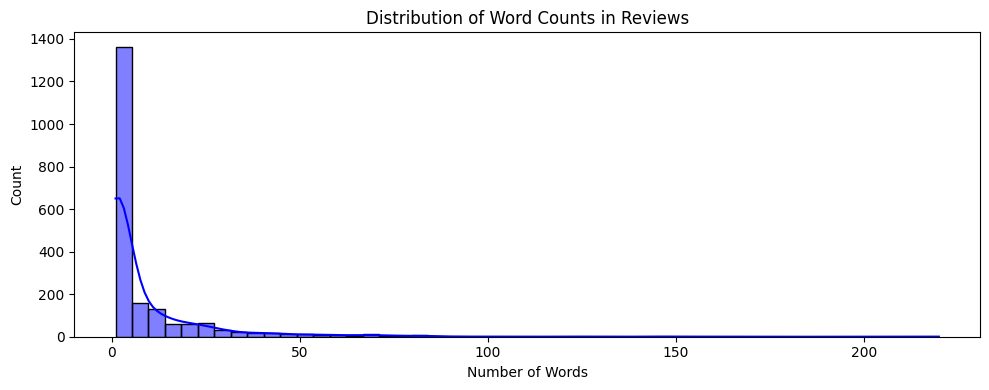

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT embedding: 100%|██████████| 2000/2000 [02:56<00:00, 11.36it/s]


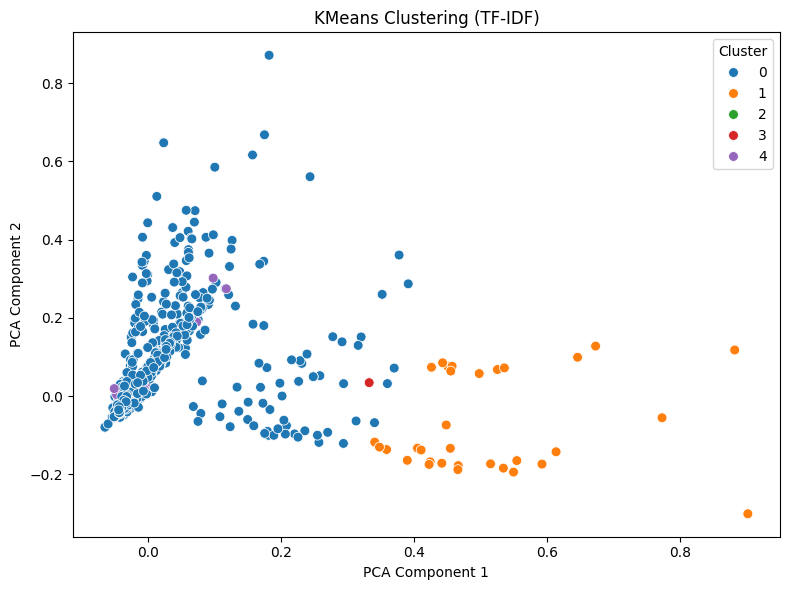

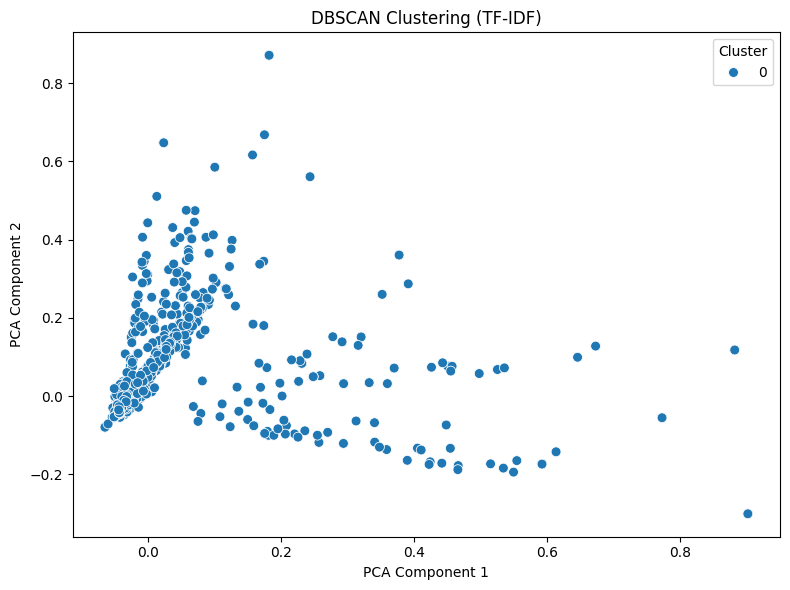

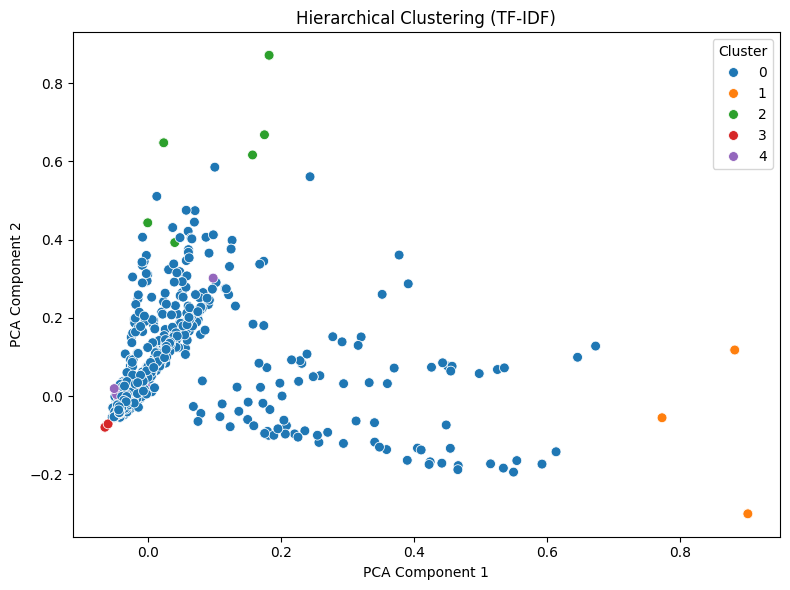

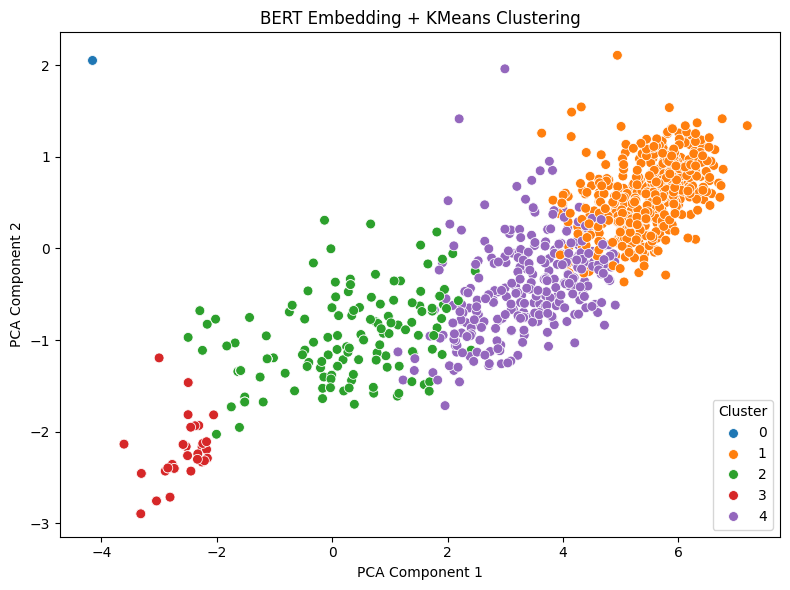

In [4]:
import pandas as pd               # For data manipulation
import numpy as np                # For numerical operations
import matplotlib.pyplot as plt   # For plotting
import seaborn as sns             # For enhanced visualizations
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

# Load the Amazon mobile reviews dataset, skipping malformed lines and handling quotes
review_data = pd.read_csv(
    "/content/Amazon_Unlocked_Mobile.csv",
    on_bad_lines='skip',
    quoting=3,
    encoding='utf-8'
)

# Remove rows where the review text is missing
review_data = review_data.dropna(subset=['Reviews']).copy()

# Sample down to 2,000 reviews for faster prototyping
review_data = review_data.sample(2000, random_state=42)

# Normalize text: convert all reviews to lowercase strings
review_data['Reviews'] = review_data['Reviews'].astype(str).str.lower()

# Compute basic text statistics: word count and character count
review_data['Token_Count'] = review_data['Reviews'].apply(lambda x: len(x.split()))
review_data['Character_Count'] = review_data['Reviews'].apply(lambda x: len(x))

# Plot the distribution of word counts across reviews
plt.figure(figsize=(10, 4))
sns.histplot(review_data['Token_Count'], bins=50, kde=True, color='blue')
plt.title('Distribution of Word Counts in Reviews')
plt.xlabel('Number of Words')
plt.tight_layout()
plt.show()

# Convert the corpus into a TF-IDF matrix (limit to top 1000 terms)
text_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = text_vectorizer.fit_transform(review_data['Reviews'])

# Clustering on TF-IDF features

# 1) K-Means clustering
kmeans_model = KMeans(n_clusters=5, random_state=42)
review_data['KMeans_Cluster'] = kmeans_model.fit_predict(tfidf_matrix)

# 2) DBSCAN clustering (uses cosine distance)
dbscan_model = DBSCAN(eps=1.2, min_samples=5, metric='cosine')
review_data['DBSCAN_Cluster'] = dbscan_model.fit_predict(tfidf_matrix)

# 3) Agglomerative (hierarchical) clustering
agglo_model = AgglomerativeClustering(n_clusters=5)
# .toarray() because AgglomerativeClustering expects dense input
review_data['Agglomerative_Cluster'] = agglo_model.fit_predict(tfidf_matrix.toarray())

# BERT-based embeddings and clustering

# Load pretrained BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

def extract_bert_embedding(text_input):

    encoded = bert_tokenizer(
        text_input,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=64
    )
    with torch.no_grad():
        output = bert_model(**encoded)
    # Average across the sequence dimension
    return output.last_hidden_state.mean(dim=1).squeeze().numpy()

# Compute BERT embeddings for each review (this can take some time)
bert_feature_matrix = np.array([
    extract_bert_embedding(text)
    for text in tqdm(review_data['Reviews'], desc="BERT embedding")
])

# Cluster the BERT embeddings with K-Means
bert_cluster_model = KMeans(n_clusters=5, random_state=42)
review_data['BERT_Cluster'] = bert_cluster_model.fit_predict(bert_feature_matrix)



def visualize_clusters(data_points, labels, chart_title):

    pca_model = PCA(n_components=2)
    coords = pca_model.fit_transform(
        data_points.toarray() if hasattr(data_points, 'toarray') else data_points
    )
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=coords[:, 0],
        y=coords[:, 1],
        hue=labels,
        palette='tab10',
        s=50
    )
    plt.title(chart_title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

# Visualize each clustering result
visualize_clusters(tfidf_matrix, review_data['KMeans_Cluster'], "KMeans Clustering (TF-IDF)")
visualize_clusters(tfidf_matrix, review_data['DBSCAN_Cluster'], "DBSCAN Clustering (TF-IDF)")
visualize_clusters(tfidf_matrix, review_data['Agglomerative_Cluster'], "Hierarchical Clustering (TF-IDF)")
visualize_clusters(bert_feature_matrix, review_data['BERT_Cluster'], "BERT Embedding + KMeans Clustering")


**In one paragraph, please compare the results of K-means, DBSCAN, Hierarchical clustering, Word2Vec, and BERT.**

**Write your response here:**

The hierarchical clustering algorithm generated a discernible review tree structure yet required human decision to determine the segmentation points. The DBSCAN algorithm effectively detected compact similar clusters within the review vectors and labeled outlier reviews as part of its noise category yet failed to identify spread-out clusters. When running K-means clustering on TF-IDF vectors it split the reviews into comparable size groups that resembled balls yet the algorithm incorrectly combined reviews that should not have been paired.  Word2Vec technique turned review texts into averaged word embeddings which created clusters that exhibited word similarity patterns although losing some contextual understanding of sentences. BERT achieved the most interpretable review clusters through its contextual embeddings yet performed slower processing than its counterparts.

.

.

.

.




# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises and on Teaching Assistant by filling this form:

https://docs.google.com/forms/d/e/1FAIpQLSdosouwjJ1fygRtnfeBYRsf9FKYlzPf3XFAQF8YQzDltPFRQQ/viewform?usp=dialog

**(Your submission will not be graded if this question is left unanswered)**

